In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support

In [2]:
### READING DATASET ###

# Paths
dataset_path = 'Dataset'
games_dir = next(os.walk(dataset_path))[1]

tag_to_skip = ['highlights', 'highlights2', '.DS_Store', '.git']
dt = np.dtype([('a', float), ('b', float), ('name', np.unicode_, 16)])

# Iterating through games
games_data = []
games_path = [os.path.join(dataset_path, g) for g in games_dir]
for path in games_path:
    game_name = os.path.basename(path)
    if game_name != 'ned_svk':
        game_info = os.listdir(path)
        data = dict()
        for info in game_info:
            tag_name = os.path.splitext(info)[0]
            if tag_name not in tag_to_skip:
                csv_file = os.path.join(path, info)
                if tag_name == 'highlights_boundaries':
                    data_value = np.genfromtxt(csv_file, delimiter=',', dtype=None)
                else:
                    data_value = np.fromfile(csv_file, dtype=np.float64)
                data[tag_name] = data_value
            data['name'] = game_name
        games_data.append(data)

games_backup = games_data[:]

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [3]:
### REMOVENDO VALORES CORRELACIONADOS ###

to_remove = ['em_mcs_energy', 'em_mcs_energy_diff', 'em_mcs_energy_diff_ascending']
for game in games_data:
    for tag in to_remove:
        del game[tag]

In [4]:
### CRIANDO VETOR DE GT ###

normal_cases = ['Normal', 'Inicio', 'Fim']
to_skip = ['name', 'highlights_boundaries']

for game in games_data:
    h = game['highlights_boundaries']
    end = h[-1][0]
    gt = np.zeros(end)
    slices = []
    for line in h:
        tag = line[2].decode('UTF-8').split(' ')
        name = [t for t in tag if t != ''][0]
        if name not in normal_cases:
            gt[line[0]-1:line[1]] = 1
        else:
            slices.append([line[0], line[1], name])

    slices = slices[::-1]
    ## Removing data not to be considered ###
    for k, values in game.items():
        if k not in to_skip:
            for sl in slices:
                if 'Fim' in sl[2]:
                    values = np.delete(values, range(sl[0], len(values)))
                if 'Normal' in sl[2]:
                    values = np.delete(values, range(sl[0], sl[1]))
                if 'Inicio' in sl[2]:
                    values = np.delete(values, range(0, sl[0]))
        game[k] = values
                    
            
    game['gt'] = gt
    del game['highlights_boundaries']

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [5]:
### CORTANDO VALORES EXCEDENTES PARA QUE TODOS OS DADOS TENHAM O MESMO TAMANHO ###

for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    min_l = min(values)
    for k, v in game.items():
        if len(v) > min_l:
            game[k] = v[:min_l]
            

### ZERO PADDING ###
max_length = 0
for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    max_length = max(values) if max(values)>max_length else max_length

for game in games_data:
    for k, v in game.items():
        if k not in ['name']:
            zero_v = np.zeros(max_length)
            if len(v) < max_length:
                zero_v[:len(v)] = v
                game[k] = zero_v

In [6]:
### DIVIDING SPLITS FROM TRAIN, EVAL, TEST ###

from sklearn.model_selection import train_test_split

games_name = [g['name'] for g in games_data]
games_train1, games_test = train_test_split(games_name, test_size=0.15)
games_train2, games_val = train_test_split(games_train1, test_size=0.05)

print('Total train: {}'.format(len(games_train2)))
print('Total test: {}'.format(len(games_test)))
print('Total val: {}'.format(len(games_val)))

Total train: 22
Total test: 5
Total val: 2


In [7]:
for i, tag_name in enumerate(games_data[10].keys()):
    print('{} - {}'.format(i, tag_name))
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i
        
print('\nnme_id: {}, gt_id: {}'.format(name_id, gt_id))

0 - dc_hue_mean
1 - name
2 - dc_percent
3 - em_cs_energy
4 - em_cs_energy_diff
5 - em_cs_energy_diff_ascending
6 - em_st_energy
7 - em_st_energy_diff
8 - em_st_energy_diff_ascending
9 - pc_delta
10 - pc_rho
11 - pc_theta
12 - pc_var_delta
13 - pc_var_theta
14 - pm_pitch
15 - pm_pitch_diff
16 - pm_pitch_diff_ascending
17 - gt

nme_id: 1, gt_id: 17


In [8]:
X_train = []
y_train = []

for game in games_data:
    if game['name'] in games_train1:
        values_array = np.array(list(game.values()))
        # Getting GT
        y_train += list(values_array[gt_id])
        
        # Removing name and GT to train
        values_array = np.delete(values_array, (max(name_id, gt_id)), axis=0)
        values_array = np.delete(values_array, (min(name_id, gt_id)), axis=0)
        
        values_array = np.array(values_array[:].tolist())
        if len(X_train) == 0:
            X_train = np.transpose(values_array)
        else:
            X_train = np.concatenate((X_train, np.transpose(values_array)))
y_train = np.array(y_train)    


X_test = []
y_test = []

for game in games_data:
    if game['name'] in games_test:
        values_array = np.array(list(game.values()))
        # Getting GT
        y_test += list(values_array[gt_id])
        
        # Removing name and GT to train
        values_array = np.delete(values_array, (max(name_id, gt_id)), axis=0)
        values_array = np.delete(values_array, (min(name_id, gt_id)), axis=0)
        
        values_array = np.array(values_array[:].tolist())
        if len(X_test) == 0:
            X_test = np.transpose(values_array)
        else:
            X_test = np.concatenate((X_test, np.transpose(values_array)))
y_test = np.array(y_test)
            

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (2000880, 16) (2000880,)
Test (416850, 16) (416850,)


training: constant learning-rate
Training set score: 0.988129
Training set loss: 0.063323
training: constant with momentum
Training set score: 0.988129
Training set loss: 0.063274
training: constant with Nesterov's momentum
Training set score: 0.988129
Training set loss: 0.063274
training: inv-scaling learning-rate
Training set score: 0.988129
Training set loss: 0.063315
training: inv-scaling with momentum
Training set score: 0.988129
Training set loss: 0.063255
training: inv-scaling with Nesterov's momentum
Training set score: 0.988129
Training set loss: 0.063261
training: adam
Training set score: 0.988129
Training set loss: 0.063280


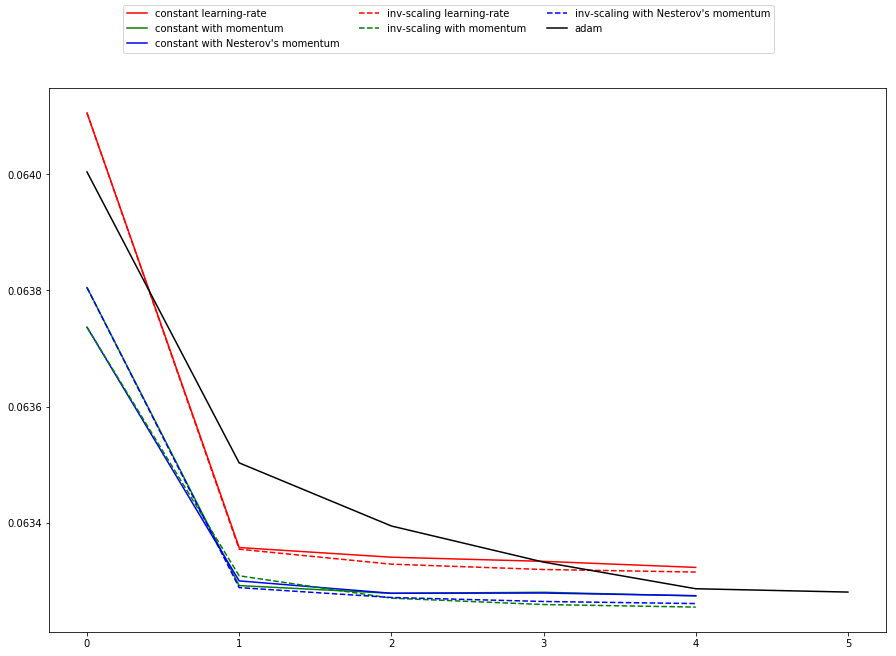

In [9]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
X = MinMaxScaler().fit_transform(X_train)
mlps = []
if name == "digits":
    # digits is larger but converges fairly quickly
    max_iter = 15
else:
    max_iter = 400

for label, param in zip(labels, params):
    print("training: %s" % label)
    mlp = MLPClassifier(verbose=0, random_state=0,
                        max_iter=max_iter, **param)
    mlp.fit(X, y_train)
    mlps.append(mlp)
    print("Training set score: %f" % mlp.score(X, y_train))
    print("Training set loss: %f" % mlp.loss_)
for mlp, label, args in zip(mlps, labels, plot_args):
    ax.plot(mlp.loss_curve_, label=label, **args)


fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(len(scaler.mean_))

[-6.34093553e-017 -8.44037611e-017  2.30682780e-017  8.83526412e-018
  3.62889468e-276  2.37785082e-017  4.23297220e-017  3.62889468e-276
  1.50994948e-017  9.23853025e-277  0.00000000e+000  1.00568601e-017
 -2.81251173e-018  9.65629027e-017 -3.36649131e-017  3.62150386e-276]
16


In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [19]:
predictions = mlp.predict(X_test)

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[412463      0]
 [  4387      0]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99    412463
        1.0       0.00      0.00      0.00      4387

avg / total       0.98      0.99      0.98    416850



C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
